<a href="https://colab.research.google.com/github/lgpatruyo/Heart-Condition-Classification/blob/main/LSTM_2L_NoPBN_2FC_Rebal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Modules

In [ ]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, LSTM
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical

In [ ]:
# Modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Importing metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline


# Collecting Data

In [ ]:
# IMPORTING DATA WITH NO HEART CONDITION (NORMAL) FROM MY DRIVE
df_normal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_Project/Data/ptbdb_normal.csv', header=None)

In [ ]:
# IMPORTING DATA WITH HEART CONDITION (ABNORMAL) FROM MY DRIVE
df_abnormal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_Project/Data/ptbdb_abnormal.csv', header=None)

In [ ]:
df_abnormal.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,0.649870,0.635100,0.655083,0.664639,0.633362,0.746308,0.871416,0.938314,1.000000,0.948740,0.396177,0.000000,0.039096,0.128584,0.305821,0.640313,0.617724,0.537793,0.352737,0.220678,0.256299,0.357950,0.482189,0.570808,0.577758,0.620330,0.622068,0.618593,0.626412,0.612511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,0.125101,0.129136,0.137207,0.137207,0.132365,0.126715,0.158192,0.152542,0.132365,0.168684,0.156578,0.183212,0.191283,0.204197,0.230024,0.244552,0.285714,0.307506,0.321227,0.327684,0.351897,0.373688,0.397094,0.363196,0.340597,0.307506,0.258273,0.197740,0.199354,0.173527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df = pd.concat([df_normal, df_abnormal], axis=0, ignore_index=True)

In [ ]:
X_data = df.loc[:,:186]
y_data = df.loc[:,187]

In [ ]:
X_data.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186
0,1.0,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,0.106564,0.106969,0.115883,0.122366,0.122366,0.11953,0.115883,0.122366,0.126013,0.133712,0.134927,0.142626,0.151135,0.158428,0.163695,0.173825,0.188817,0.207861,0.230956,0.258509,0.294571,0.325770,0.362642,0.398298,0.429498,0.449352,0.450972,0.418963,0.372771,0.310373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,0.361781,0.362400,0.366110,0.367965,0.374150,0.37786,0.382189,0.384663,0.398887,0.401361,0.418058,0.443414,0.457638,0.487941,0.520717,0.559678,0.604205,0.634508,0.653680,0.672851,0.678417,0.660482,0.621521,0.555968,0.482375,0.438466,0.378479,0.351268,0.319728,0.306741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Preliminary ECG Visuals

<Figure size 720x144 with 0 Axes>

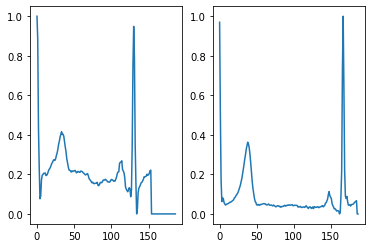

<Figure size 720x144 with 0 Axes>

In [ ]:
#Normal ECG (picked randomly)
plt.subplot(1,2,1)
plt.plot(df_normal.loc[100,:186])
plt.subplot(1,2,2)
plt.plot(df_normal.loc[500,:])
plt.figure(figsize=(10,2))


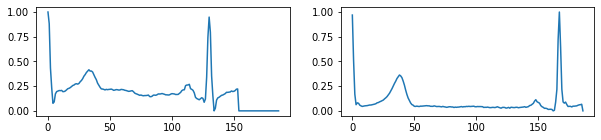

In [ ]:
fig = plt.figure(figsize=(10, 2))

# Adds subplot on position 1
ax = fig.add_subplot(121)
# Adds subplot on position 2
ax2 = fig.add_subplot(122)

ax.plot(df_normal.loc[100,:186])
ax2.plot(df_normal.loc[500,:186])
plt.show()

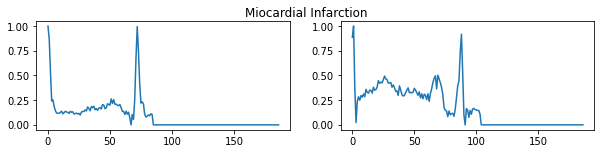

In [ ]:
#Abnormal ECG
fig1 = plt.figure(figsize=(10, 2))

# Adds subplot on position 1
ax = fig1.add_subplot(121)
# Adds subplot on position 2
ax2 = fig1.add_subplot(122)

ax.plot(df_abnormal.loc[100,:186])
ax2.plot(df_abnormal.loc[500,:186])

plt.suptitle('Miocardial Infarction') 
plt.show()

In [ ]:
y_data.value_counts()

1.0    10506
0.0     4046
Name: 187, dtype: int64

# Splitting Data & Setting "y" Categorical

In [ ]:
dfX_train, dfX_test, y_train, y_test = train_test_split(X_data, y_data, shuffle=True, train_size=0.8, random_state = 42)

In [ ]:
y_train

4292     1.0
8963     1.0
10671    1.0
8994     1.0
13691    1.0
        ... 
5191     1.0
13418    1.0
5390     1.0
860      0.0
7270     1.0
Name: 187, Length: 11641, dtype: float64

In [ ]:
#Preparing the train dataset including "y" before balancing the classes.
df_train = pd.concat([dfX_train, pd.Series(y_train)], axis=1)

In [ ]:
df_train[187].value_counts()

1.0    8429
0.0    3212
Name: 187, dtype: int64

In [ ]:
y_test.value_counts()

1.0    2077
0.0     834
Name: 187, dtype: int64

# Balancing Classes in Train Set

In [ ]:
from sklearn.utils import resample

df_0=(df_train[df_train[187]==0])
df_1=(df_train[df_train[187]==1]).sample(n=8400,random_state=42)

#resampling minority class with replacement
df_0_upsample=resample(df_0,replace=True,n_samples=8400,random_state=123)

#balanced df
df_train_balanced=pd.concat([df_0_upsample,df_1])

#shuffling rows in balanced df
df_train_shuffled=df_train_balanced.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train_shuffled[187].value_counts()

0.0    8400
1.0    8400
Name: 187, dtype: int64

In [ ]:
X_train_proc = df_train_shuffled.iloc[:,:187]
y_train_proc = df_train_shuffled.iloc[:,187]

In [ ]:
X_train_proc.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186
0,1.0,0.858808,0.661917,0.576425,0.458549,0.379534,0.233161,0.161917,0.119171,0.084197,0.102332,0.042746,0.129534,0.180052,0.121762,0.151554,0.081606,0.150259,0.204663,0.097150,0.190415,0.031088,0.142487,0.090674,0.034974,0.077720,0.012953,0.066062,0.126943,0.054404,0.132124,0.154145,0.182642,0.156736,0.159326,0.246114,0.195596,0.240933,0.200777,0.159326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.916993,0.617071,0.274863,0.180110,0.273297,0.142522,0.073610,0.075176,0.061081,0.087706,0.072044,0.064213,0.098669,0.110415,0.133908,0.137823,0.144088,0.189507,0.173845,0.176194,0.204385,0.215348,0.245106,0.222396,0.291308,0.295223,0.260767,0.306186,0.300705,0.306186,0.282694,0.299922,0.299922,0.273297,0.266249,0.224745,0.187940,0.180893,0.163665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Formatting Train and Test

In [ ]:
#X_train_proc comes from rebalancing classes in train_set above
X_train = X_train_proc.iloc[:,:186].values

#dfx_test comes from splitting train/test section
X_test = dfX_test.iloc[:,:186].values

#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])

# Changing the shape of X_train and X_test to3D arrays

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)


In [ ]:
X_test.shape

(2911, 186, 1)

In [ ]:
y_train_cat=to_categorical(y_train_proc)
y_test_cat=to_categorical(y_test)

In [ ]:
y_train_cat

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# LSTM NN

# Network Definition







In [ ]:
#reference for understanding LSTM return sequence parameter
#https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/

def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_lstm=Input(shape=(im_shape), name='inputs_lstm')
    lstm_1=LSTM(units=64, return_sequences=True, input_shape=im_shape)(inputs_lstm)
    #conv1_1=BatchNormalization()(conv1_1)
    #pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    lstm_2=LSTM(units=64, return_sequences=True)(lstm_1)
    #conv2_1=BatchNormalization()(conv2_1)
    #pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    #conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    #conv3_1=BatchNormalization()(conv3_1)
    #pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(lstm_2)
    #dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(flatten)
    main_output = Dense(2, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train, epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [ ]:
model,history=network(X_train,y_train_cat,X_test,y_test_cat)

Epoch 1/40
525/525 [==============================] - 43s 18ms/step - loss: 0.4735 - accuracy: 0.7719 - val_loss: 0.2494 - val_accuracy: 0.8877
Epoch 2/40
525/525 [==============================] - 8s 16ms/step - loss: 0.2623 - accuracy: 0.8922 - val_loss: 0.1803 - val_accuracy: 0.9323
Epoch 3/40
525/525 [==============================] - 8s 16ms/step - loss: 0.2024 - accuracy: 0.9180 - val_loss: 0.1764 - val_accuracy: 0.9344
Epoch 4/40
525/525 [==============================] - 8s 16ms/step - loss: 0.1339 - accuracy: 0.9480 - val_loss: 0.1599 - val_accuracy: 0.9457
Epoch 5/40
525/525 [==============================] - 8s 16ms/step - loss: 0.0988 - accuracy: 0.9646 - val_loss: 0.1040 - val_accuracy: 0.9681
Epoch 6/40
525/525 [==============================] - 8s 16ms/step - loss: 0.0768 - accuracy: 0.9699 - val_loss: 0.1494 - val_accuracy: 0.9516
Epoch 7/40
525/525 [==============================] - 8s 16ms/step - loss: 0.0713 - accuracy: 0.9755 - val_loss: 0.0932 - val_accuracy: 0.970

# Model Evaluation

In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

    #Luis: Changed from strings to integer
    target_names=[0, 1]
    
    #y_true=[]
    #for element in y_test:
    #    y_true.append(np.argmax(element))
    #prediction_proba=model.predict(X_test)
    #prediction=np.argmax(prediction_proba,axis=1)
    #cnf_matrix = confusion_matrix(y_true, prediction)
    

Accuracy: 98.80%


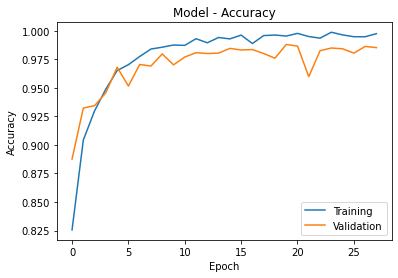

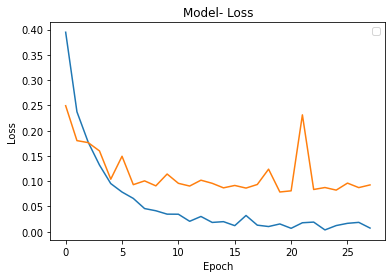

In [ ]:
evaluate_model(history,X_test,y_test_cat,model)

In [ ]:
y_pred=model.predict(X_test)
y_pred

array([[1.0000000e+00, 1.4458354e-10],
       [1.3334219e-01, 8.6665779e-01],
       [8.1802742e-09, 1.0000000e+00],
       ...,
       [9.6569885e-04, 9.9903429e-01],
       [1.0000000e+00, 5.0422045e-08],
       [4.5866543e-16, 1.0000000e+00]], dtype=float32)

In [ ]:
y_test_cat

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
y_check = y_test_cat.argmax(axis=1)
np.count_nonzero(y_check == 1)

2077

In [ ]:
#
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


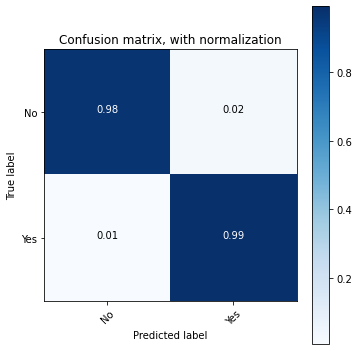

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['No', 'Yes'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
target_names = ['No', 'Yes']
print(classification_report(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1),target_names=target_names))

              precision    recall  f1-score   support

          No       0.98      0.98      0.98       834
         Yes       0.99      0.99      0.99      2077

    accuracy                           0.99      2911
   macro avg       0.99      0.98      0.99      2911
weighted avg       0.99      0.99      0.99      2911

